In [1]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch


In [2]:
os.makedirs('images', exist_ok=True)


n_epochs = 400
batch_size = 32
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 2
latent_dim = 100
img_width = 76
img_height = 128
channels = 3
n_critic = 0.01
clip_value = 0.01
sample_interval = 50


In [3]:
img_shape = (channels, img_height, img_width)

cuda = True if torch.cuda.is_available() else False

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [  nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [6]:
# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
# os.makedirs('../data/img_align_celeba', exist_ok=True)
celeba_data = dset.ImageFolder(root='../data/img_align_celeba/'
                              ,
                       transform=transforms.Compose([
                       transforms.Resize((img_height, img_width)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ]))
dataloader = torch.utils.data.DataLoader(
                       celeba_data,
                       batch_size=batch_size, shuffle=True)

In [7]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [8]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(outputs=d_interpolates, inputs=interpolates,
                              grad_outputs=fake, create_graph=True, retain_graph=True,
                              only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [9]:
# ----------
#  Training
# ----------

d_learning = []
g_learning = []

batches_done = 0

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)
        
        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

             # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs,
                                                            i, len(dataloader),
                                                            d_loss.item(), g_loss.item()))
            d_learning.append(d_loss.item())
            g_learning.append(g_loss.item())
        
                
        if int(batches_done) % sample_interval == 0:
            save_image(fake_imgs.data[:25], 'images/%08d.png' % batches_done, nrow=5, normalize=True)
        batches_done += n_critic
        
        
        
       

[Epoch 0/400] [Batch 0/1024] [D loss: 9.953530] [G loss: 0.037026]
[Epoch 1/400] [Batch 0/1024] [D loss: -602540.625000] [G loss: 10687.118164]
[Epoch 2/400] [Batch 0/1024] [D loss: -1075412.125000] [G loss: -1839.067017]
[Epoch 3/400] [Batch 0/1024] [D loss: -918749.312500] [G loss: -3217.467285]
[Epoch 4/400] [Batch 0/1024] [D loss: -1213637.750000] [G loss: -6093.393555]
[Epoch 5/400] [Batch 0/1024] [D loss: -1113777.250000] [G loss: -11299.908203]
[Epoch 6/400] [Batch 0/1024] [D loss: -1011574.500000] [G loss: -17643.078125]
[Epoch 7/400] [Batch 0/1024] [D loss: -1155230.750000] [G loss: -23671.115234]
[Epoch 8/400] [Batch 0/1024] [D loss: -1258888.125000] [G loss: -32047.433594]
[Epoch 9/400] [Batch 0/1024] [D loss: -1223924.625000] [G loss: -41435.578125]
[Epoch 10/400] [Batch 0/1024] [D loss: -1296398.000000] [G loss: -54503.492188]
[Epoch 11/400] [Batch 0/1024] [D loss: -1027959.500000] [G loss: -63159.582031]
[Epoch 12/400] [Batch 0/1024] [D loss: -1317098.000000] [G loss: -79

[Epoch 103/400] [Batch 0/1024] [D loss: -657661.500000] [G loss: 18024.556641]
[Epoch 104/400] [Batch 0/1024] [D loss: -761302.875000] [G loss: 85196.000000]
[Epoch 105/400] [Batch 0/1024] [D loss: -528440.875000] [G loss: 18083.839844]
[Epoch 106/400] [Batch 0/1024] [D loss: -809715.000000] [G loss: 79634.429688]
[Epoch 107/400] [Batch 0/1024] [D loss: -560377.875000] [G loss: 21381.630859]
[Epoch 108/400] [Batch 0/1024] [D loss: -778638.000000] [G loss: 85359.210938]
[Epoch 109/400] [Batch 0/1024] [D loss: -709657.062500] [G loss: 110699.890625]
[Epoch 110/400] [Batch 0/1024] [D loss: -543145.125000] [G loss: 81535.453125]
[Epoch 111/400] [Batch 0/1024] [D loss: -601533.312500] [G loss: 103830.921875]
[Epoch 112/400] [Batch 0/1024] [D loss: -776591.562500] [G loss: 67371.343750]
[Epoch 113/400] [Batch 0/1024] [D loss: -530234.375000] [G loss: 44800.113281]
[Epoch 114/400] [Batch 0/1024] [D loss: -681788.562500] [G loss: 78245.023438]
[Epoch 115/400] [Batch 0/1024] [D loss: -727988.37

[Epoch 207/400] [Batch 0/1024] [D loss: -455857.312500] [G loss: 117439.640625]
[Epoch 208/400] [Batch 0/1024] [D loss: -546973.625000] [G loss: 107590.976562]
[Epoch 209/400] [Batch 0/1024] [D loss: -443812.156250] [G loss: 96703.226562]
[Epoch 210/400] [Batch 0/1024] [D loss: -509041.093750] [G loss: 111036.750000]
[Epoch 211/400] [Batch 0/1024] [D loss: -411826.625000] [G loss: 105621.250000]
[Epoch 212/400] [Batch 0/1024] [D loss: -489990.156250] [G loss: 106944.062500]
[Epoch 213/400] [Batch 0/1024] [D loss: -489476.093750] [G loss: 100029.609375]
[Epoch 214/400] [Batch 0/1024] [D loss: -469694.781250] [G loss: 122454.554688]
[Epoch 215/400] [Batch 0/1024] [D loss: -470806.937500] [G loss: 88644.125000]
[Epoch 216/400] [Batch 0/1024] [D loss: -512209.000000] [G loss: 117897.632812]
[Epoch 217/400] [Batch 0/1024] [D loss: -395522.750000] [G loss: 102694.203125]
[Epoch 218/400] [Batch 0/1024] [D loss: -475062.437500] [G loss: 85905.031250]
[Epoch 219/400] [Batch 0/1024] [D loss: -44

[Epoch 311/400] [Batch 0/1024] [D loss: -408970.062500] [G loss: 68700.007812]
[Epoch 312/400] [Batch 0/1024] [D loss: -417843.781250] [G loss: 91426.648438]
[Epoch 313/400] [Batch 0/1024] [D loss: -420613.343750] [G loss: 77249.085938]
[Epoch 314/400] [Batch 0/1024] [D loss: -445582.000000] [G loss: 84664.492188]
[Epoch 315/400] [Batch 0/1024] [D loss: -468483.031250] [G loss: 100239.109375]
[Epoch 316/400] [Batch 0/1024] [D loss: -452467.062500] [G loss: 90796.062500]
[Epoch 317/400] [Batch 0/1024] [D loss: -407596.875000] [G loss: 67131.609375]
[Epoch 318/400] [Batch 0/1024] [D loss: -461068.468750] [G loss: 105260.765625]
[Epoch 319/400] [Batch 0/1024] [D loss: -441649.437500] [G loss: 66101.125000]
[Epoch 320/400] [Batch 0/1024] [D loss: -472080.718750] [G loss: 105475.757812]
[Epoch 321/400] [Batch 0/1024] [D loss: -432835.468750] [G loss: 79164.945312]
[Epoch 322/400] [Batch 0/1024] [D loss: -428456.875000] [G loss: 78176.421875]
[Epoch 323/400] [Batch 0/1024] [D loss: -463124.6

In [10]:
!ls images

00000000.png  00000850.png  00001700.png  00002550.png	00003400.png
00000050.png  00000900.png  00001750.png  00002600.png	00003450.png
00000100.png  00000950.png  00001800.png  00002650.png	00003500.png
00000150.png  00001000.png  00001850.png  00002700.png	00003550.png
00000200.png  00001050.png  00001900.png  00002750.png	00003600.png
00000250.png  00001100.png  00001950.png  00002800.png	00003650.png
00000300.png  00001150.png  00002000.png  00002850.png	00003700.png
00000350.png  00001200.png  00002050.png  00002900.png	00003750.png
00000400.png  00001250.png  00002100.png  00002950.png	00003800.png
00000450.png  00001300.png  00002150.png  00003000.png	00003850.png
00000500.png  00001350.png  00002200.png  00003050.png	00003900.png
00000550.png  00001400.png  00002250.png  00003100.png	00003950.png
00000600.png  00001450.png  00002300.png  00003150.png	00004000.png
00000650.png  00001500.png  00002350.png  00003200.png	00004050.png
00000700.png  00001550.png  00002400.png  000032

In [11]:
!ls images/ -l . | egrep -c '^-'

91


In [12]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('images/*.png'): #assuming gif
    im=Image.open(filename)
    image_list.append(im)

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def get_sample(array,x):
  steps = int(len(array)/(x-1))  
  new_array = []
  for i in range(0,x-1):    
    new_array.append(array[i*steps])
  new_array.append(array[-1])  
  return new_array

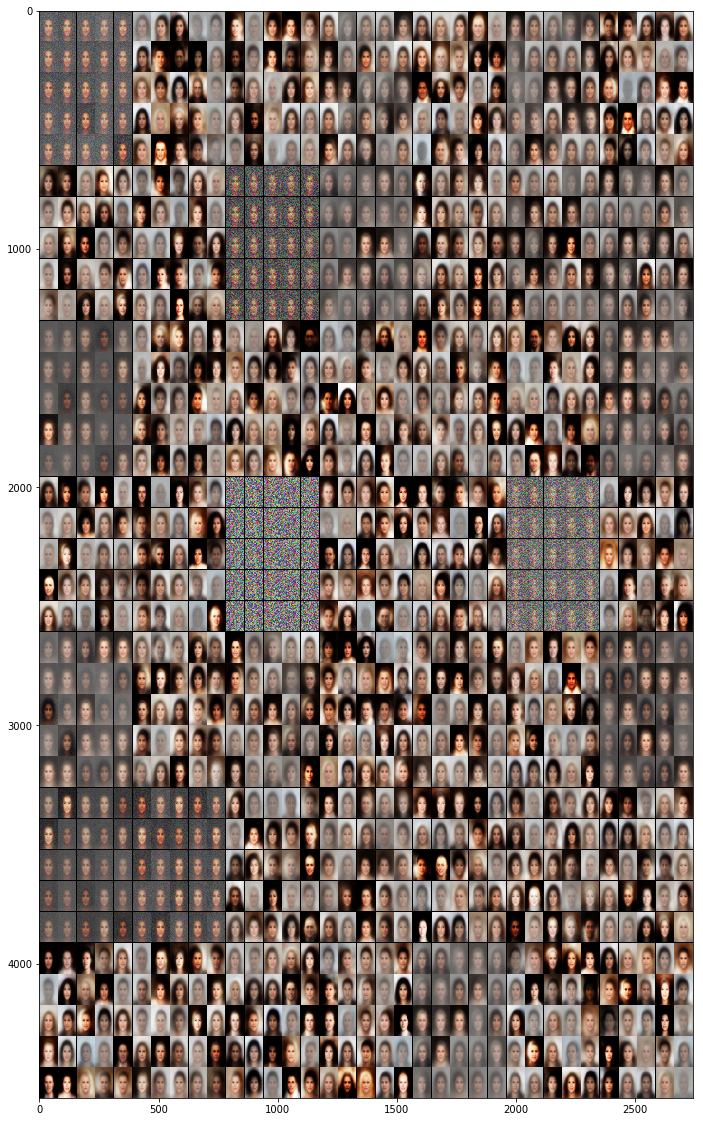

In [18]:

def gallery(array, ncols=7):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def make_array(image_array):      
    return np.array([np.array(img) for img in image_array])    

array = make_array(get_sample(image_list,49))
result = gallery(array)
plt.figure(figsize=(13,20))
plt.imshow(result)
plt.show()

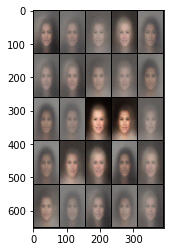

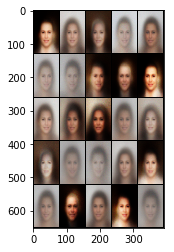

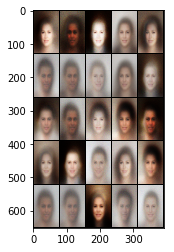

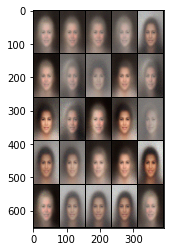

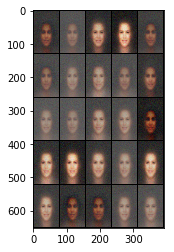

In [15]:
plt.imshow(image_list[10])
plt.show()
plt.imshow(image_list[-4])
plt.show()
plt.imshow(image_list[-5])
plt.show()
plt.imshow(image_list[-6])
plt.show()
plt.imshow(image_list[-7])
plt.show()

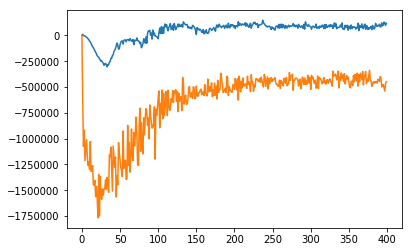

In [16]:
plt.plot(g_learning)
plt.plot(d_learning)
plt.show()

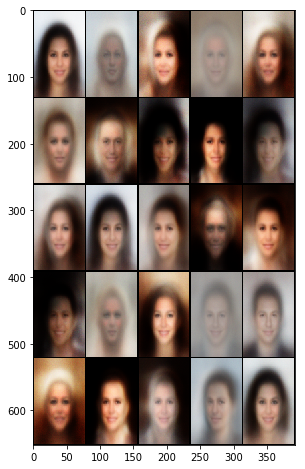

In [37]:
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
save_image(generator(z).data[:25], 'images/prueba.png', nrow=5, normalize=True)
im=Image.open('images/prueba.png')
plt.figure(figsize=(8,8))
plt.imshow(im)
plt.show()